In [3]:
import numpy as np 
import pandas as pd

In [3]:
pip install pandas

  Using cached pandas-1.5.2-cp38-cp38-win_amd64.whl (11.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install matplotlib

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install tqdm


     ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install tensorflow

     ------------------------------------- 266.3/266.3 MB 11.3 MB/s eta 0:00:00
     --------------------------------------- 14.2/14.2 MB 34.4 MB/s eta 0:00:00
  Using cached termcolor-2.1.1-py3-none-any.whl (6.2 kB)
     ---------------------------------------- 6.0/6.0 MB 34.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 35.6 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 47.6 MB/s eta 0:00:00
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     ------------------------------------- 895.9/895.9 kB 55.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 34.2 MB/s eta 0:00:00
     ---------------------------------------- 439.2/439.2 kB ? eta 0:00:00
     ------------------------------------- 177.0/177.0 kB 11.1 MB/s eta 0:00:00
     --------------------------

# Importing Required Libraries

In [9]:

import tensorflow as tf
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import datetime
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images

# Input Files

In [13]:
input_files = []
input_masks = glob('./kaggle_3m/*/*_mask*')

for i in input_masks:
    input_files.append(i.replace('_mask',''))

display(input_files[:1])
display(input_masks[:1])

   

['./kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif']

['./kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif']

# Plotting Images

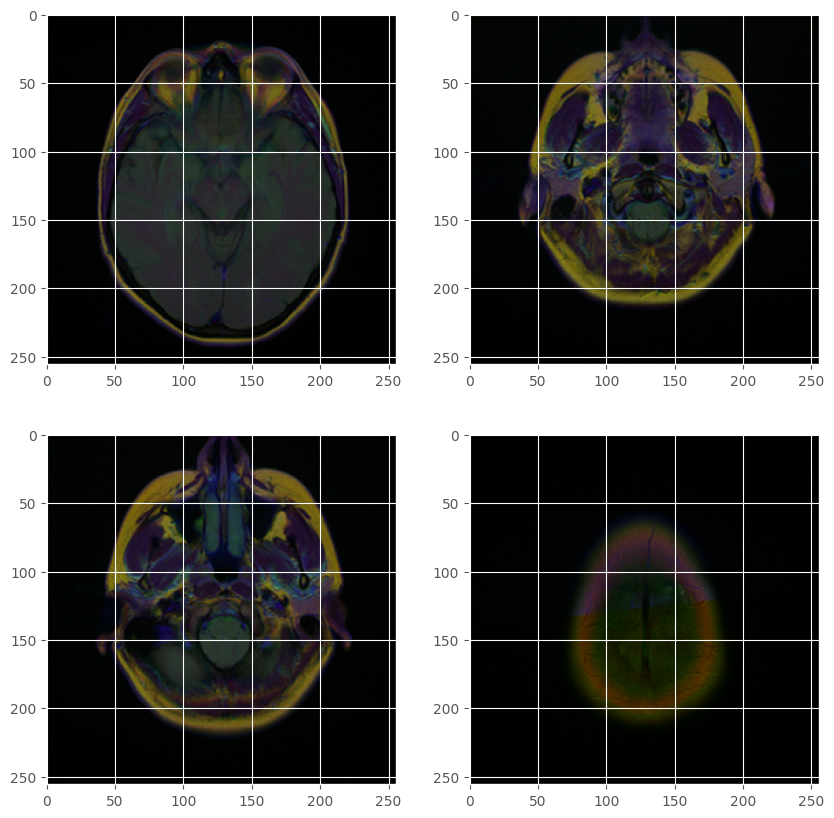

In [14]:
def print_images(r : int = 3, c : int = 3):
    
    fig = plt.figure(figsize = (10, 10))

    for i in range(1, r * c + 1):
        fig.add_subplot(r, c, i)
        image_path = input_files[i]
        mask_path = input_masks[i]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(mask_path)
        plt.imshow(img)
        plt.imshow(msk, alpha = 0.4)
    
    plt.show()

print_images(r = 2, c = 2) 

# Image and Mask Generation

In [8]:
def train_generator(data_frame        : pd.DataFrame(),
                    batch        : int,
                    aug_dict          : dict(),
                    image_mode  = "rgb",
                    mask_mode   = "grayscale",
                    image_prefix = "image",
                    mask_prefix  = "mask",
                    save_to_dir       = None,
                    target_size       = (256, 256),
                    seed              = 1
                 
                  ):
    
    """ Using ImageDataGenerator to Generate image and mask at a time"""


    interm_image_data_gen = ImageDataGenerator(**aug_dict)
    interm_mask_datagen = ImageDataGenerator(**aug_dict)
    
    img_generator = interm_image_data_gen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "filename",
                                                        class_mode   = None,
                                                        color_mode   = image_mode,
                                                        target_size  = target_size,
                                                        batch   = batch,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = image_prefix,
                                                        seed = seed
                                                        )

    mask_generator = interm_mask_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "mask",
                                                        class_mode   = None,
                                                        color_mode   = mask_mode,
                                                        target_size  = target_size,
                                                        batch   = batch,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = mask_prefix,
                                                        seed         = seed
                                                      )

    train_gen = zip(img_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = transform_data(img, mask)
        yield (img, mask)

def transform_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# Spliting Data into Train Validation Test sets

In [18]:
def split_data():

    mri_input = pd.DataFrame(data = {"filename" : input_files, 
                                "mask"    : input_masks}
                       )
    
    train_data, test_data       = train_test_split(mri_input, test_size = 0.1)
    train_data, validation_data = train_test_split(train_data, test_size = 0.2)
    
    return train_data, test_data, validation_data

train_data, validation_data, test_data = split_data()

display(train_data.values.shape)
display(test_data.values.shape)
display(validation_data.values.shape)

(1468, 2)

(367, 2)

(204, 2)

In [11]:
img_height = 256
img_width  = 256

# Unet MODEL

In [12]:
def UNet_Model(input_size = (256, 256, 3)):
    
    
    inputs = Input(input_size)
    conv_1 = Conv2D(filters   = 64,
                   kernel_size             = (3, 3),
#                    kernel_initializer      = my_filter,
                   padding                 = 'SAME')(inputs)
    
    
    b_normalization_1        = Activation('relu')(conv_1)
    conv_1 = Conv2D(64, (3, 3), padding = 'SAME')(b_normalization_1)
    b_normalization_1        = BatchNormalization(axis = 3)(conv_1)
    b_normalization_1        = Activation('relu')(b_normalization_1)
    max_pool_1           = MaxPooling2D(pool_size = (2, 2))(b_normalization_1)


    conv_2 = Conv2D(128, (3, 3), padding = 'SAME')(max_pool_1)
    b_normalization_2         = Activation('relu')(conv_2)
    conv_2 = Conv2D(128, (3, 3), padding = 'SAME')(b_normalization_2)
    b_normalization_2         = BatchNormalization(axis=3)(conv_2)
    b_normalization_2         = Activation('relu')(b_normalization_2)
    max_pool_2           = MaxPooling2D(pool_size=(2, 2))(b_normalization_2)



    conv_3 = Conv2D(256, (3, 3), padding = 'SAME')(max_pool_2)
    b_normalization_3        = Activation('relu')(conv_3)
    conv_3 = Conv2D(256, (3, 3), padding = 'SAME')(b_normalization_3)
    b_normalization_3        = BatchNormalization(axis = 3)(conv_3)
    b_normalization_3        = Activation('relu')(b_normalization_3)
    max_pool_3           = MaxPooling2D(pool_size = (2, 2))(b_normalization_3)


    conv_4 = Conv2D(512, (3, 3), padding = 'SAME')(max_pool_3)
    b_normalization_4        = Activation('relu')(conv_4)
    conv_4 = Conv2D(512, (3, 3), padding = 'SAME')(b_normalization_4)
    b_normalization_4        = BatchNormalization(axis = 3)(conv_4)
    b_normalization_4        = Activation('relu')(b_normalization_4)
    max_pool_4           = MaxPooling2D(pool_size = (2, 2))(b_normalization_4)


    conv_5 = Conv2D(1024, (3, 3), padding = 'SAME')(max_pool_4)
    b_normalization_5        = Activation('relu')(conv_5)
    conv_5 = Conv2D(1024, (3, 3), padding = 'SAME')(b_normalization_5)
    b_normalization_5        = BatchNormalization(axis=3)(conv_5)
    b_normalization_5        = Activation('relu')(b_normalization_5)


    decoder_6       = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding = 'SAME')(b_normalization_5), conv_4], axis=3)
    conv_6 = Conv2D(512, (3, 3), padding='same')(decoder_6)
    b_normalization_6        = Activation('relu')(conv_6)
    conv_6 = Conv2D(512, (3, 3), padding='same')(b_normalization_6)
    b_normalization_6        = BatchNormalization(axis=3)(conv_6)
    b_normalization_6        = Activation('relu')(b_normalization_6)



    decoder_7       = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding = 'SAME')(b_normalization_6), conv_3], axis=3)
    conv_7 = Conv2D(256, (3, 3), padding = 'SAME')(decoder_7)
    b_normalization_7        = Activation('relu')(conv_7)
    conv_7 = Conv2D(256, (3, 3), padding = 'SAME')(b_normalization_7)
    b_normalization_7        = BatchNormalization(axis = 3)(conv_7)
    b_normalization_7        = Activation('relu')(b_normalization_7)


    decoder_8       = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(b_normalization_7), conv_2], axis=3)
    conv_8 = Conv2D(128, (3, 3), padding = 'SAME')(decoder_8)
    b_normalization_8        = Activation('relu')(conv_8)
    conv_8 = Conv2D(128, (3, 3), padding = 'SAME')(b_normalization_8)
    b_normalization_8        = BatchNormalization(axis = 3)(conv_8)
    b_normalization_8        = Activation('relu')(b_normalization_8)


    decoder_9       = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'SAME')(b_normalization_8), conv_1], axis=3)
    conv_9 = Conv2D(64, (3, 3), padding = 'SAME')(decoder_9)
    b_normalization_9        = Activation('relu')(conv_9)
    conv_9 = Conv2D(64, (3, 3), padding = 'SAME')(b_normalization_9)
    b_normalization_9        = BatchNormalization(axis = 3)(conv_9)
    b_normalization_9        = Activation('relu')(b_normalization_9)

    conv_10 = Conv2D(1, (1, 1), activation = 'sigmoid')(b_normalization_9)

    return Model(inputs = [inputs], outputs = [conv_10])

In [13]:
model = UNet_Model()

In [14]:
# Setting up the parameters
EPOCHS          = 25
BATCH_SIZE      = 32
LR   = 1e-3

# Adding Random Noise to Train Data

In [15]:
VAR = 50


def add_random_noise(img):
    deviation = VAR * random.random()
    noise     = np.random.normal(0, deviation, img.shape)
    img       += noise
    
    np.clip(img, 0., 255.)
    return img


# Specifying Loss Function and Evaluation Metrics

In [9]:
smooth = 100

def dice_coef(y_true, y_pred):
    y_t_flattened = K.flatten(y_true)
    y_p_flattened = K.flatten(y_pred)
    sum_1 = K.sum(y_t_flattened * y_p_flattened)
    return((2 * sum_1 + smooth) / (K.sum(y_t_flattened) + K.sum(y_p_flattened) + smooth))

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):

    intersect = K.sum(y_true * y_pred)
    sum_t = K.sum(y_true + y_pred)
    jac_dist = (intersect + smooth) / (sum_t - intersect + smooth)
    return jac_dist


# COMPILATION OF MODEL

In [16]:


train_arguements = dict(
                            height_shift_range     = 0.05,
                            shear_range            = 0.05,
                            zoom_range             = 0.05,
                            rotation_range         = 0.2,
                            width_shift_range      = 0.05,
                            horizontal_flip        = True,
                            fill_mode              = 'nearest',
                            )

train_gen = train_generator(train_data,
                            BATCH_SIZE,
                            train_arguements,
                            target_size = (img_height, img_width))
    
test_gen = train_generator(validation_data,
                             BATCH_SIZE,
                             dict(),
                             target_size = (img_height, img_width))
    
model = UNet_Model(input_size=(img_height, img_width, 3))

DR = LR / EPOCHS

opt = Adam(learning_rate  = LR,
                  beta_1  = 0.9, 
                  beta_2  = 0.999,
                  epsilon = None,
                  decay   = DR, 
                  amsgrad = False)

model.compile(optimizer = opt, 
              loss      = dice_coef_loss,
              metrics   = ["binary_accuracy", iou, dice_coef])

callbacks = ModelCheckpoint('Unet_Brain_MRI_V2.hdf5', 
                            verbose        = 1, 
                            save_best_only = True)

training_log = TensorBoard(log_dir = 'training_logs/')

# TRAINING

In [19]:
history = model.fit(train_gen,
                    steps_per_epoch  = len(train_data) / BATCH_SIZE, 
                    epochs           = EPOCHS, 
                    callbacks        = [callbacks, training_log],
                    validation_data  = test_gen,
                    validation_steps = len(validation_data) / BATCH_SIZE)

Epoch 1/25
46/45 [==============================] - ETA: -8s - loss: -0.5918 - binary_accuracy: 0.9929 - iou: 0.4267 - dice_coef: 0.5915
Epoch 1: val_loss did not improve from -0.27184
45/45 [==============================] - 3226s 71s/step - loss: -0.5918 - binary_accuracy: 0.9929 - iou: 0.4267 - dice_coef: 0.5915 - val_loss: -0.0732 - val_binary_accuracy: 0.7437 - val_iou: 0.0409 - val_dice_coef: 0.0780
Epoch 2/25
46/45 [==============================] - ETA: -9s - loss: -0.5693 - binary_accuracy: 0.9925 - iou: 0.4083 - dice_coef: 0.5687 
Epoch 2: val_loss did not improve from -0.27184
45/45 [==============================] - 3459s 76s/step - loss: -0.5693 - binary_accuracy: 0.9925 - iou: 0.4083 - dice_coef: 0.5687 - val_loss: -0.1118 - val_binary_accuracy: 0.8677 - val_iou: 0.0601 - val_dice_coef: 0.1127
Epoch 3/25
46/45 [==============================] - ETA: -8s - loss: -0.6318 - binary_accuracy: 0.9937 - iou: 0.4683 - dice_coef: 0.6315 
Epoch 3: val_loss did not improve from -0.2

# TRAINING LOSS AND ACCURACY

C:\Users\essha\AppData\Local\Temp\ipykernel_17472\1854331289.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("Loss Plots.jpg",figsize=(8,8))
C:\Users\essha\AppData\Local\Temp\ipykernel_17472\1854331289.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fisize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))


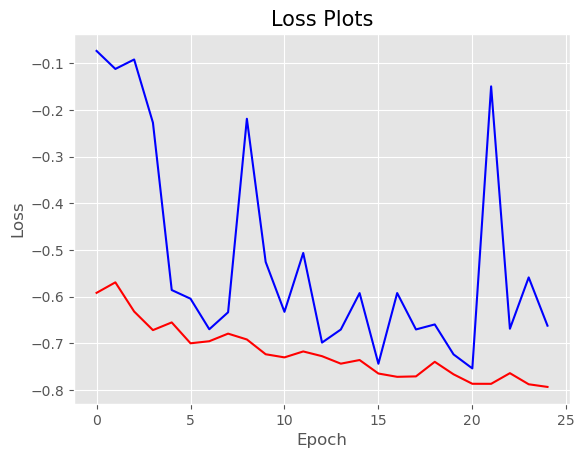

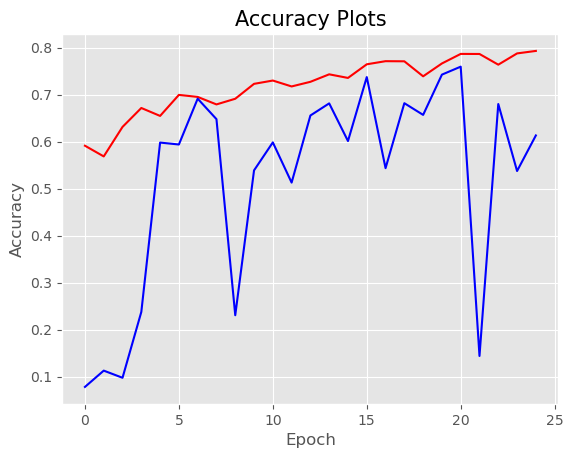

In [20]:
def plots():

    HGST = history.history

    train_dice    = HGST['dice_coef']
    test_dice     = HGST['val_dice_coef']
    train_loss    = HGST['loss']
    test_loss     = HGST['val_loss']
    
    plt.figure(1)
    plt.plot(test_loss, 'b-')
    plt.plot(train_loss,'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plots', fontsize = 15)
    plt.savefig("Loss Plots.jpg",figsize=(8,8))
    
    plt.figure(2)
    plt.plot(train_dice, 'r-')
    plt.plot(test_dice, 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plots', fontsize = 15)
    plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))
    plt.show()
    
plots()

In [21]:
test_gen = train_generator(test_data,
                           BATCH_SIZE,
                           dict(),
                           target_size = (img_height, img_width))

output = model.evaluate(test_gen, 
                         steps = len(test_data) / BATCH_SIZE)

print("Test loss: ",            output[0])
print("Test IOU: ",             output[1])
print("Test Dice Coefficent: ", output[2])

Found 367 validated image filenames.
Found 367 validated image filenames.
11/11 [==============================] - 155s 14s/step - loss: -0.7387 - binary_accuracy: 0.9948 - iou: 0.6042 - dice_coef: 0.7443
Test loss:  -0.7387009263038635
Test IOU:  0.9947653412818909
Test Dice Coefficent:  0.6041706204414368


# Model Prediction On Test Set

1/1 [==============================] - 1s 913ms/step


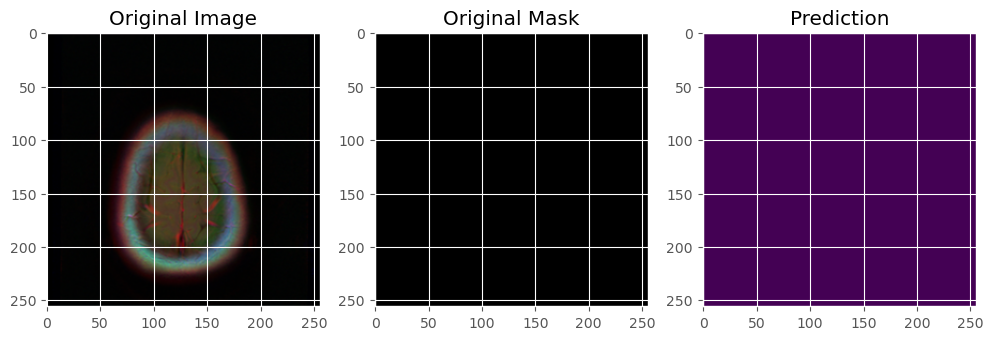

1/1 [==============================] - 0s 426ms/step


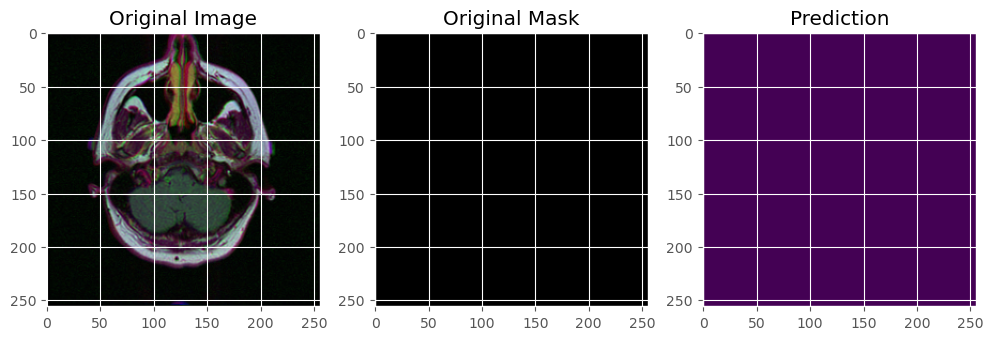

1/1 [==============================] - 0s 411ms/step


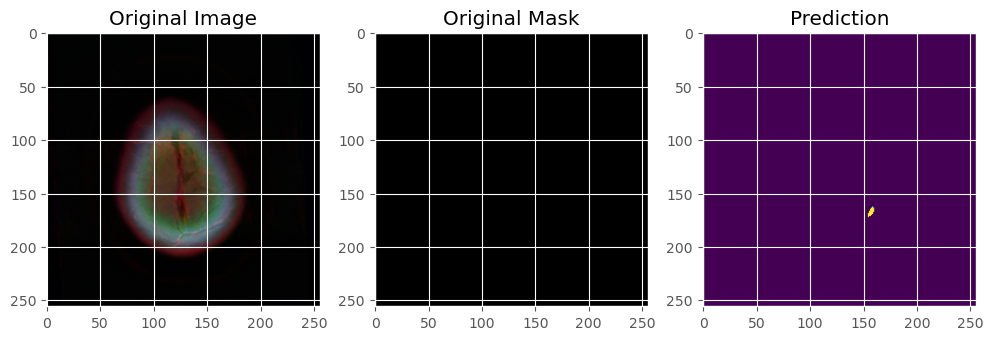

1/1 [==============================] - 0s 388ms/step


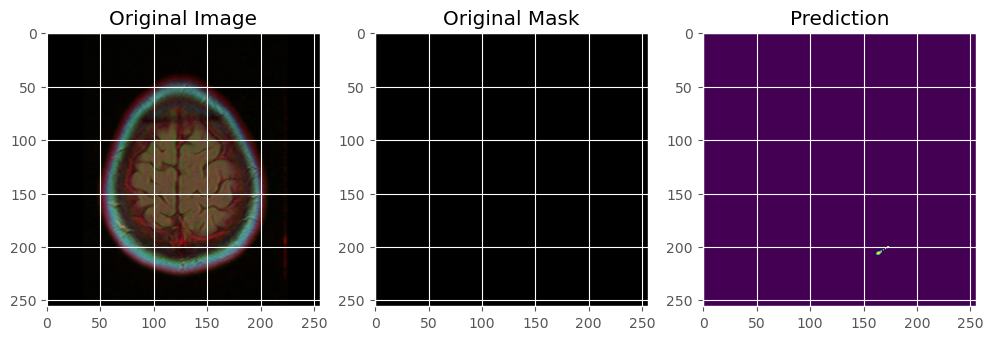

1/1 [==============================] - 0s 376ms/step


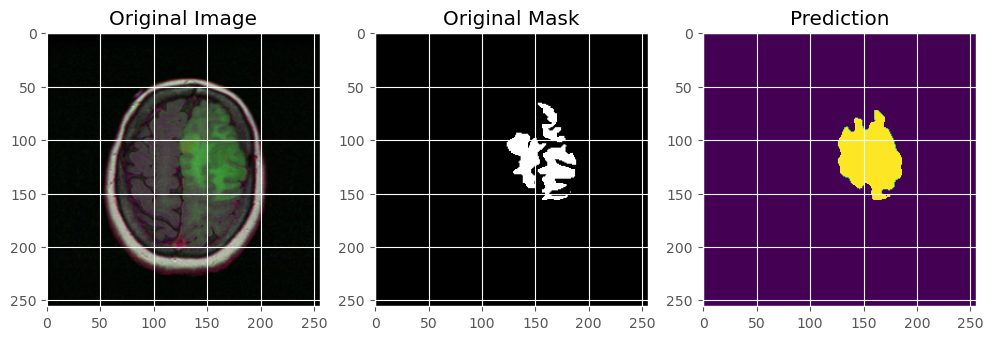

In [22]:

def prediction(Num_images : int = None):

    for i in range(Num_images):

        ind = np.random.randint(1, len(test_data.ind))
        img = cv2.imread(test_data['filename'].iloc[ind])
        img = cv2.resize(img,(img_height, img_width))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        P = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(test_data['mask'].iloc[ind])))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(P) > .5)
        plt.title('Prediction')
        plt.show()

prediction(5)